In [76]:
import glob
import importlib
import json
import re

import os
from pathlib import Path
from typing import List, Tuple

import joblib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import string
import seaborn as sns
from seaborn import barplot
from tqdm.notebook import trange, tqdm

In [77]:
import rdkit
from rdkit.Contrib.SA_Score import sascorer
from rdkit.DataStructs import BulkTanimotoSimilarity
import rdkit.ML.Cluster.Butina
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator


In [78]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [79]:
def validate_smile(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

In [80]:
def cluster_mols(smiles, cutoff=0.2):
    """ Cluster SMILES using Butina method """
    fpgen = rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048, countSimulation=True)
    fps = [fpgen.GetFingerprint(rdkit.Chem.MolFromSmiles(smi)) for smi in smiles]
    nbrLists = []
    for i in range(len(fps)):
        sims = 1 - np.asarray(BulkTanimotoSimilarity(fps[i], fps[:i]), dtype=np.float32)
        nbrLists.extend(sims.tolist())
    cs = rdkit.ML.Cluster.Butina.ClusterData(nbrLists, len(fps), distThresh=cutoff, isDistData=True)
    clusters = np.zeros(len(fps), dtype=int)
    for i, v in enumerate(cs):
        clusters[list(v)] = i
    return clusters

In [81]:
class BoostWrapper(object):
    """ Help joblib to deal with boost functions """

    def __init__(self, method_name, module_name):
        self.method_name = method_name
        self.module = importlib.import_module(module_name)

    @property
    def method(self):
        return getattr(self.module, self.method_name)

    def __call__(self, *args, **kwargs):
        return self.method(*args, **kwargs)
    

def smiles_to_mols(smiles, n_jobs=8):

    if isinstance(smiles, (list, tuple, np.ndarray)):
        pass
    elif isinstance(smiles, pd.Series):
        smiles = smiles.tolist()
    else:
        raise TypeError(f"{type(smiles)=}")

    assert len(smiles) > 0
    assert isinstance(smiles[0], str), f"expect smiles string, got f{smiles[0]}"

    mols = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(BoostWrapper('MolFromSmiles', 'rdkit.Chem.rdmolfiles', ))(smi) for smi in smiles)
    return mols


def smiles_to_fps(smiles_or_mols, finger_type='rdkit', n_jobs=8, fp_param=None):

    if isinstance(smiles_or_mols, (list, tuple, np.ndarray)):
        pass
    elif isinstance(smiles_or_mols, pd.Series):
        smiles_or_mols = smiles_or_mols.tolist()
    else:
        raise TypeError(f"{type(smiles_or_mols)=}")

    assert len(smiles_or_mols) > 0
    assert isinstance(smiles_or_mols[0], (str, rdkit.Chem.rdchem.Mol)), f"variable {smiles_or_mols[0]} has type {type(smiles_or_mols[0])}"

    if isinstance(smiles_or_mols[0], str):
        mols = smiles_to_mols(smiles_or_mols)
    else:
        mols = smiles_or_mols

    if fp_param is None:
        fp_param = {}
    fp_func, fp_func_name, fp_func_module, fp_params = _find_fingerprint_function(finger_type)
    fp_params.update(fp_param)
    if finger_type == 'morgan':
        fp_func = fp_func(**fp_params).GetFingerprint
        fp_params = {}
    fps = joblib.Parallel(n_jobs=n_jobs, prefer="threads")(
        joblib.delayed(fp_func)(mol, **fp_params) for mol in mols)
    return fps


def _find_fingerprint_function(finger_type: str) -> Tuple[callable, str, str, dict]:
    kwargs = {}
    if finger_type == 'rdkit':
        fp_func_name = 'RDKFingerprint'
        fp_func_module = 'rdkit.Chem'
    elif finger_type == 'maccs':
        fp_func_name = 'GetMACCSKeysFingerprint'
        fp_func_module = 'rdkit.Chem.rdMolDescriptors'
    elif finger_type == 'morgan':
        fp_func_name = 'GetMorganGenerator'
        fp_func_module = 'rdkit.Chem.AllChem'
        kwargs = dict(atomInvariantsGenerator=rdkit.Chem.rdFingerprintGenerator.GetMorganFeatureAtomInvGen(),
                      radius=2, fpSize=2048, countSimulation=True)
    else:
        raise NotImplementedError(f"Use `rdkit` or `maccs` or `morgan` as fps")

    fp_func = getattr(importlib.import_module(fp_func_module), fp_func_name)
    return fp_func, fp_func_name, fp_func_module, kwargs

## Add Tanimoto similarity to generated molecules

In [82]:
gen_models = [ 'protobind_diff', 'reinvent', 'pocket2mol', 
              'pocketflow', 'tamgen', 'targetdiff']

# Take only clustered mols for actives_bindingdb
model_names = ['actives_bindingdb_cl'] + gen_models

n_mols_per_model = [None] + [1000]*(len(gen_models))

gene2file = {}
base_path = Path(os.getcwd()).parent
save_dir = base_path / 'results'
os.makedirs(save_dir, exist_ok=True)

for model_name in model_names:
    if model_name == 'actives_bindingdb_cl':
        tables_path = glob.glob(str(base_path / f'data/{model_name}/*.csv'))
    else:
        tables_path = glob.glob(str(base_path / f'data/{model_name}/generated_*.csv'))
    gene2file[model_name] = dict(zip([os.path.splitext(os.path.basename(tables_path[i]))[0].split('_')[-1] 
                                      for i in range(len(tables_path))], tables_path))
    
name_order = np.array(['ESR1', 'HCRTR1', 'JAK1', 'P2RX3', 'KDM1A', 'IDH1', 
                       'RIOK1', 'NR4A1', 'GRIK1', 'CCR9', 'FTO', 'SPIN1'])

## Calculate chem descriptors

In [83]:
def calc_chem_desc(smiles):
    rdkit_features = {'MolWt': Descriptors.MolWt,
                      'MolLogP': Descriptors.MolLogP,
                      'NumRotatableBonds': Descriptors.NumRotatableBonds,
                      'CalcTPSA': rdkit.Chem.rdMolDescriptors.CalcTPSA,
                      'RingCount': rdkit.Chem.Descriptors.RingCount,
                      'QED': rdkit.Chem.QED.default,
                      'SAScore': sascorer.calculateScore,
                      'GetNumHeavyAtoms': rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms,
                      'CalcNumAromaticRings': rdkit.Chem.rdMolDescriptors.CalcNumAromaticRings,
                      'CalcFractionCSP3': rdkit.Chem.rdMolDescriptors.CalcFractionCSP3,
                      }
    if isinstance(smiles[0], str):
        mols = smiles_to_mols(smiles)
    elif isinstance(smiles[0], rdkit.Chem.rdchem.Mol):
        mols = smiles
    else:
        raise TypeError(f'smiles must be a string or a rdkit.Chem.rdchem.Mol: {type(smiles[0])}')
    res = {}
    for name, func in rdkit_features.items():
        res[name] = np.asarray([func(m) if m is not None else np.nan for m in mols])
    return pd.DataFrame(res)


def calculate_descriptors(model_name, metrics, tables_path, n_mols=None, column_name:str='smiles', 
                          tanimoto_threshold:float=0.5, qed_threshold:float=0.5, diversity_clusters_cutoff=0.2):
    
    """
    Calculates descriptors for generated molecules.
        Uniqueness and validity: calculated for raw data.
        
        Metrics calculated after filter by Tanimoto with tanimoto_threshold and only for unique mols:
        MolWt: Molecular Weight
        MolLogP: LogP (Octanol-Water Partition Coefficient)
        NumRotatableBonds: Number of Rotatable Bonds
        CalcTPSA: Topological Polar Surface Area
        RingCount: Number of Rings
        QED: Quantitative Estimate of Drug-likeness
        SAScore: Synthetic Accessibility Score
        GetNumHeavyAtoms: Number of Heavy (Non-Hydrogen) Atoms
        CalcNumAromaticRings: Number of Aromatic Rings
        CalcFractionCSP3: Fraction of sp3-Hybridized Carbons
        FracDrugLike: fraction of attractive compounds, with drug-likeness (QED) value > qed_threshold,
        Diversity: number of unique clusters using Butina algorithm with diversity_clusters_cutoff
        
    Parameters:
        model_name (str): name of a generative model
        metrics (dict): dictionary to which descriptors with the model_name key are added
        tables_path (str): Path to CSV file with generated molecules
        n_mols (int): number of molecules specified during generation (usually only valid ones are saved)
        column_name (int): name of the column with generated molecules (molecule format)
        tanimoto_threshold (float): cutoff for filtering non-new molecules according to the Tanimoto scale 
        qed_threshold (float): cutoff to count drug-like molecules
        diversity_clusters_cutoff (float): cutoff for Butina clustering algorithm
        
    Returns:
        dict: Dictionary of metric scores per descriptor and an overall average
    """
    
    
    for idx in trange(len(tables_path)):
        
        df = pd.read_csv(tables_path[idx])
        gene_name = os.path.splitext(os.path.basename(tables_path[idx]))[0].split('_')[-1] 
        metrics[model_name][gene_name] = {}

        if n_mols is None:
            metrics[model_name][gene_name]['Validity'] = 1.0
        else:
            metrics[model_name][gene_name]['Validity'] = len(df[column_name]) / n_mols
        
        len_ = len(df[column_name])
        df = df.drop_duplicates(subset=[column_name])
        
        if 'Tanimoto' in df.columns and tanimoto_threshold < 1:
            df = df[df.Tanimoto <= tanimoto_threshold]
            metrics[model_name][gene_name]['FracNovel'] = len(df[column_name]) / len_
            metrics[model_name][gene_name]['Uniqueness'] = 0.0
        else:
            metrics[model_name][gene_name]['FracNovel'] = 1.0
            metrics[model_name][gene_name]['Uniqueness'] = len(df[column_name]) / len_
        

        mols = smiles_to_mols(df[column_name])
        chem_desc = calc_chem_desc(mols)
        
        # Chem desriptors
        for col in chem_desc.columns:
            metrics[model_name][gene_name][col] = np.nanmean(chem_desc[col])
        
        # Number of unique mols with QED > qed_threshold
        if n_mols is None:
            metrics[model_name][gene_name]['FracDrugLike'] = 1.0
        else:
            metrics[model_name][gene_name]['FracDrugLike'] = np.sum(chem_desc['QED'] > qed_threshold) / n_mols
        
        # diversity
        clusters = cluster_mols(df[column_name], cutoff=diversity_clusters_cutoff)
        metrics[model_name][gene_name]['Diversity'] = len(np.unique(clusters))/len(df[column_name])
    return metrics 

In [84]:
from rdkit.Chem import rdFingerprintGenerator


In [85]:
for tanimoto_threshold in [0.5, 1]:
    print(f'Tanimoto threshold {tanimoto_threshold}')
    metrics = {}
    for n_mols, model_name in zip(n_mols_per_model, model_names):
        metrics[model_name] = {}
        metrics = calculate_descriptors(model_name, metrics, list(gene2file[model_name].values()), 
                                        n_mols=n_mols, column_name='SMILES',
                                        tanimoto_threshold=tanimoto_threshold)
    df_metrics = []
    for m_name in list(metrics.keys()):
        df_one_model = []
        for gene in list(metrics[m_name].keys()):
            df_one_gene = pd.DataFrame([metrics[m_name][gene]])
            df_one_gene['ModelName'] = m_name
            df_one_gene['GeneName'] = gene
            df_one_model.append(df_one_gene)
        df_one_model = pd.concat(df_one_model, ignore_index=True)
        df_one_model['GeneName'] = pd.Categorical(df_one_model['GeneName'], categories=name_order, ordered=True)
        df_one_model = df_one_model.sort_values('GeneName')
        df_metrics.append(df_one_model)
    df_metrics = pd.concat(df_metrics, ignore_index=True)
    df_metrics.to_csv(base_path / f"results/chem_desc_T{tanimoto_threshold}.csv", index=False, float_format="%.2f")

Tanimoto threshold 0.5


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Tanimoto threshold 1


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [86]:
list(metrics.keys())

['actives_bindingdb_cl',
 'protobind_diff',
 'reinvent',
 'pocket2mol',
 'pocketflow',
 'tamgen',
 'targetdiff']

## Add maximum mean discrepancy (MMD) between generated molecules and active ones from BindingDB

In [87]:
def compare_descriptors(true_active_path, generated_molecules_path, model_name,
                        tanimoto_threshold=0.5, max_actives=1000, to_plot_desc=False):
    """
    Calculates a similarity metric between true active molecules and generated molecules.
    
    Parameters:
        true_active_path (str): Path to CSV file with true active molecules (SMILES format).
        generated_molecules_path (str): Path to CSV file with generated molecules (SMILES format).
        tanimoto_threshold (float): cutoff for filtering non-new molecules according to the Tanimoto scale.
        max_actives (int): Maximum number of active molecules to use for comparison.
        
    Returns:
        dict: Dictionary of metric scores per descriptor and an overall average.
    """
    scores = {}

    # load SMILES from CSVs
    true_df = pd.read_csv(true_active_path)
    gen_df = pd.read_csv(generated_molecules_path)
    gen_df = gen_df.drop_duplicates(subset=['SMILES'])
    if 'Tanimoto' in gen_df.columns:
        gen_df = gen_df[gen_df.Tanimoto <= tanimoto_threshold]
        

    # compute chemical descriptors
    true_descriptors = calc_chem_desc(smiles_to_mols(true_df['SMILES']))
    if len(true_descriptors) > max_actives:
        true_descriptors = true_descriptors.sample(max_actives)

    gen_descriptors = calc_chem_desc(smiles_to_mols(gen_df['SMILES']))
    desc_list = true_descriptors.columns
    
    if to_plot_desc:
        colors = plt.cm.tab10.colors
        figure(figsize=(15, 8), dpi=400)
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8), dpi=300, facecolor='white', 
                                 gridspec_kw={'wspace': 0.1, 'hspace': 0.5})
        axes = axes.flatten()

    # compare descriptors
    total_score = 0
    for i, descriptor in enumerate(gen_descriptors.columns):
        score = MMD(
            true_descriptors[descriptor].values.astype(np.float32),
            gen_descriptors[descriptor].values.astype(np.float32),
            true_descriptors[descriptor].std()
        )
        scores[f'{descriptor}_mmd'] = score
        total_score += score
        
        if to_plot_desc:
            sns.histplot(gen_descriptors[descriptor], bins=30, alpha=0.6,
                         ax=axes[i], label='gen', stat='probability')
            sns.histplot(true_descriptors[descriptor], bins=30, alpha=0.6, 
                         ax=axes[i], label='true', stat='probability')
            axes[i].legend()
            axes[i].set_yticks([])
            axes[i].set_title(f'{np.round(score, 3)}')
            axes[i].set_ylabel('')
    if to_plot_desc:
        axes[-1].set_visible(False)
        axes[-2].set_visible(False)
        plt.show();

    # average mmd
    scores['MMD'] = total_score / gen_descriptors.shape[1]
    return scores


def MMD(x, y, sigma):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        sigma: scaling in rbf kernel
    """

    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)

    def rbf_kernel(a, b, s):
        a_norm = (a ** 2).sum(axis=1).reshape(-1, 1)
        b_norm = (b ** 2).sum(axis=1).reshape(1, -1)
        dist = a_norm + b_norm - 2.0 * np.matmul(a, b.T)
        return np.exp(-dist / (2 * s ** 2))

    Kxx, Kyy, Kxy = 0., 0., 0.
    for k_ in [0.1, 1, 5]:
        Kxx += rbf_kernel(x, x, sigma * k_)# * (1/k_)
        Kyy += rbf_kernel(y, y, sigma * k_)# * (1/k_)
        Kxy += rbf_kernel(x, y, sigma * k_)# * (1/k_)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

def add_mmd_stats(mmd_scores, base_path, model_name, gene, paired_gene, 
                  tanimoto_threshold=0.5, to_plot_desc=False):
    tables_path1 = base_path / f'data/actives_bindingdb_cl/{paired_gene}.csv'
    tables_path2 = base_path / f'data/{model_name}/generated_{gene}.csv'
    mmd_scores[model_name][gene] = compare_descriptors(tables_path1, tables_path2, model_name,
                               tanimoto_threshold=tanimoto_threshold, to_plot_desc=to_plot_desc)
    return mmd_scores

In [88]:
# map names of hard samples to easy ones, since they contain small number of true actives in bindingdb

hard_to_easy_dict = dict(zip(name_order, name_order))

Gene ESR1


<Figure size 6000x3200 with 0 Axes>

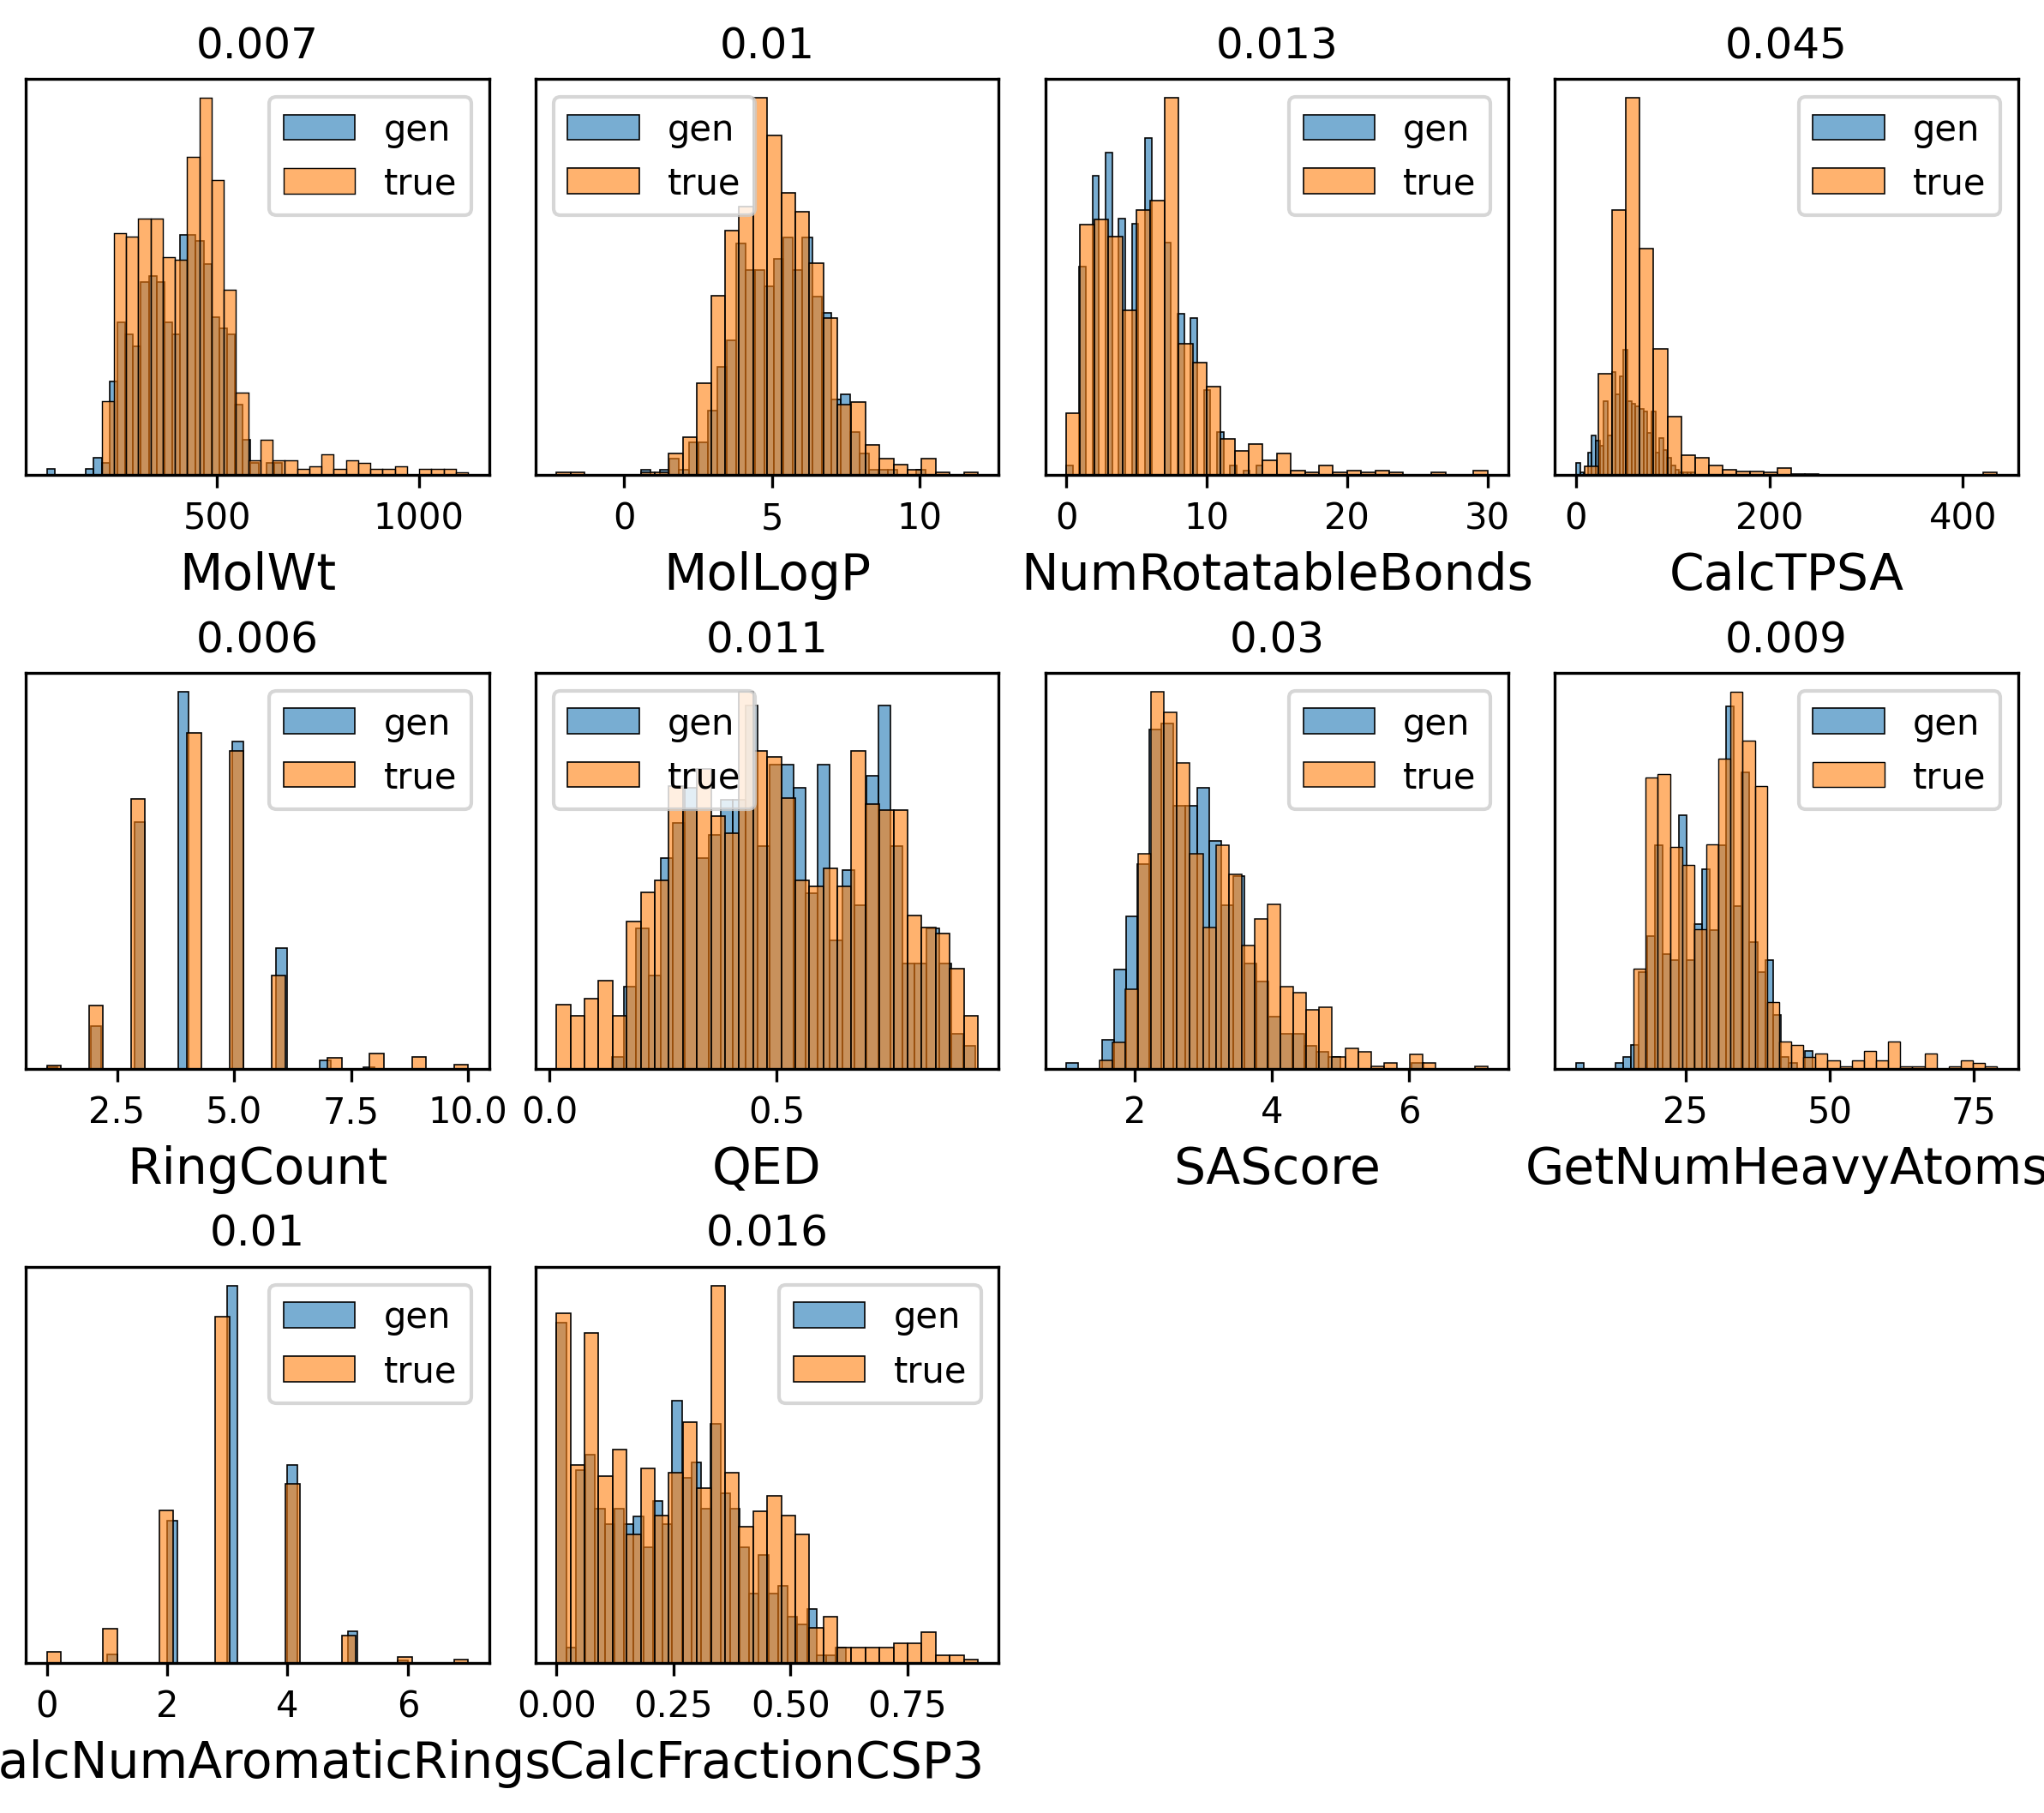

In [89]:
mmd_scores = {}
for model_name in ['protobind_diff']:
    mmd_scores[model_name] = {}
    for gene in name_order[:1]:
        print(f'Gene {gene}')
        add_mmd_stats(mmd_scores, base_path, model_name, gene, hard_to_easy_dict[gene], 
                                  tanimoto_threshold=tanimoto_threshold, to_plot_desc=True)

In [100]:
for tanimoto_threshold in [0.5, 1]:

    print(f'Tanimoto threshold {tanimoto_threshold}')
    mmd_scores = {}
    
    for model_name in gen_models:
        mmd_scores[model_name] = {}
        for gene in tqdm(name_order):
            mmd_scores = add_mmd_stats(mmd_scores, base_path, model_name, gene, hard_to_easy_dict[gene],
                                      tanimoto_threshold=tanimoto_threshold)

    df_mmd_scores = []
    for m_name in list(mmd_scores.keys()):
        df_one_model = []
        for gene in list(mmd_scores[m_name].keys()):
            df_one_gene = pd.DataFrame([mmd_scores[m_name][gene]])
            df_one_gene['ModelName'] = m_name
            df_one_gene['GeneName'] = gene
            df_mmd_scores.append(df_one_gene)

    df_mmd_scores = pd.concat(df_mmd_scores, ignore_index=True)
    cols = list(df_mmd_scores.columns)
    cols = cols[-2:] + cols[:-2]
    df_mmd_scores = df_mmd_scores[cols]
    df_mmd_scores.to_csv(base_path / f"results/mmd_T{tanimoto_threshold}.csv", index=False, float_format="%.2f")

Tanimoto threshold 0.5


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Tanimoto threshold 1


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [120]:
for tanimoto_threshold in [0.5, 1]:
    df_metrics = pd.read_csv(base_path / f"results/chem_desc_T{tanimoto_threshold}.csv")
    df_mmd_scores = pd.read_csv(base_path / f"results/mmd_T{tanimoto_threshold}.csv")
    
    df_ = pd.merge(df_mmd_scores, df_metrics, how="right", on=['ModelName', 'GeneName'])
    df_ = df_[df_.GeneName.isin(name_order)]
    df_.to_csv(base_path / f"results/metrics_T{tanimoto_threshold}.csv", index=False, float_format="%.2f")

## Plot all descriptors

In [125]:
df_metrics_T05 = pd.read_csv(base_path / f"results/metrics_T{0.5}.csv")
df_metrics_T1 = pd.read_csv(base_path / f"results/metrics_T{1}.csv")

df_metrics_T05.loc[df_metrics_T05.ModelName == 'actives_bindingdb_cl', 'MMD'] = 0.0
df_metrics_T1.loc[df_metrics_T1.ModelName == 'actives_bindingdb_cl', 'MMD'] = 0.0

In [126]:
all_mols = []
for i, gene in enumerate(name_order):
    for j, model in enumerate(['protobind_diff']):
        df = pd.read_csv(gene2file[model][gene])
        if 'Tanimoto' in df.columns:
            all_mols += list(df.Tanimoto)

In [127]:
# change names for the paper
d1 = {
    'Validity': 'Validity', 
    'Uniqueness': 'Uniqueness', 
    'FracNovel': 'FracNovel', 
    'Diversity': 'Diversity', 
    'QED': 'QED', 
    'SAScore': 'SAScore', 
    'MolWt': 'Mol. Weight',  
    'MMD': 'MMD',
    'MolLogP': 'LogP', 
    'NumRotatableBonds': 'Rotatable Bonds', 
    'CalcTPSA': 'TPSA', 
    'RingCount': 'Rings', 
    'GetNumHeavyAtoms': 'Heavy Atoms', 
    'CalcNumAromaticRings': 'Aromatic Rings',
    'CalcFractionCSP3': 'Fsp3'
}

d2 = {
    'actives_bindingdb_cl': 'BindingDB (reference)',
    'protobind_diff' : 'ProtoBind-Diff',
    'reinvent': 'REINVENT4',
    'pocket2mol': 'Pocket2Mol',
    'pocketflow': 'PocketFlow',
    'tamgen': 'TamGen',
    'targetdiff': 'TargetDiff'
}

/var/folders/wf/rxy3k0rj26j21wb0ddpvcvq40000gn/T/ipykernel_98521/1690589521.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 6000x3200 with 0 Axes>

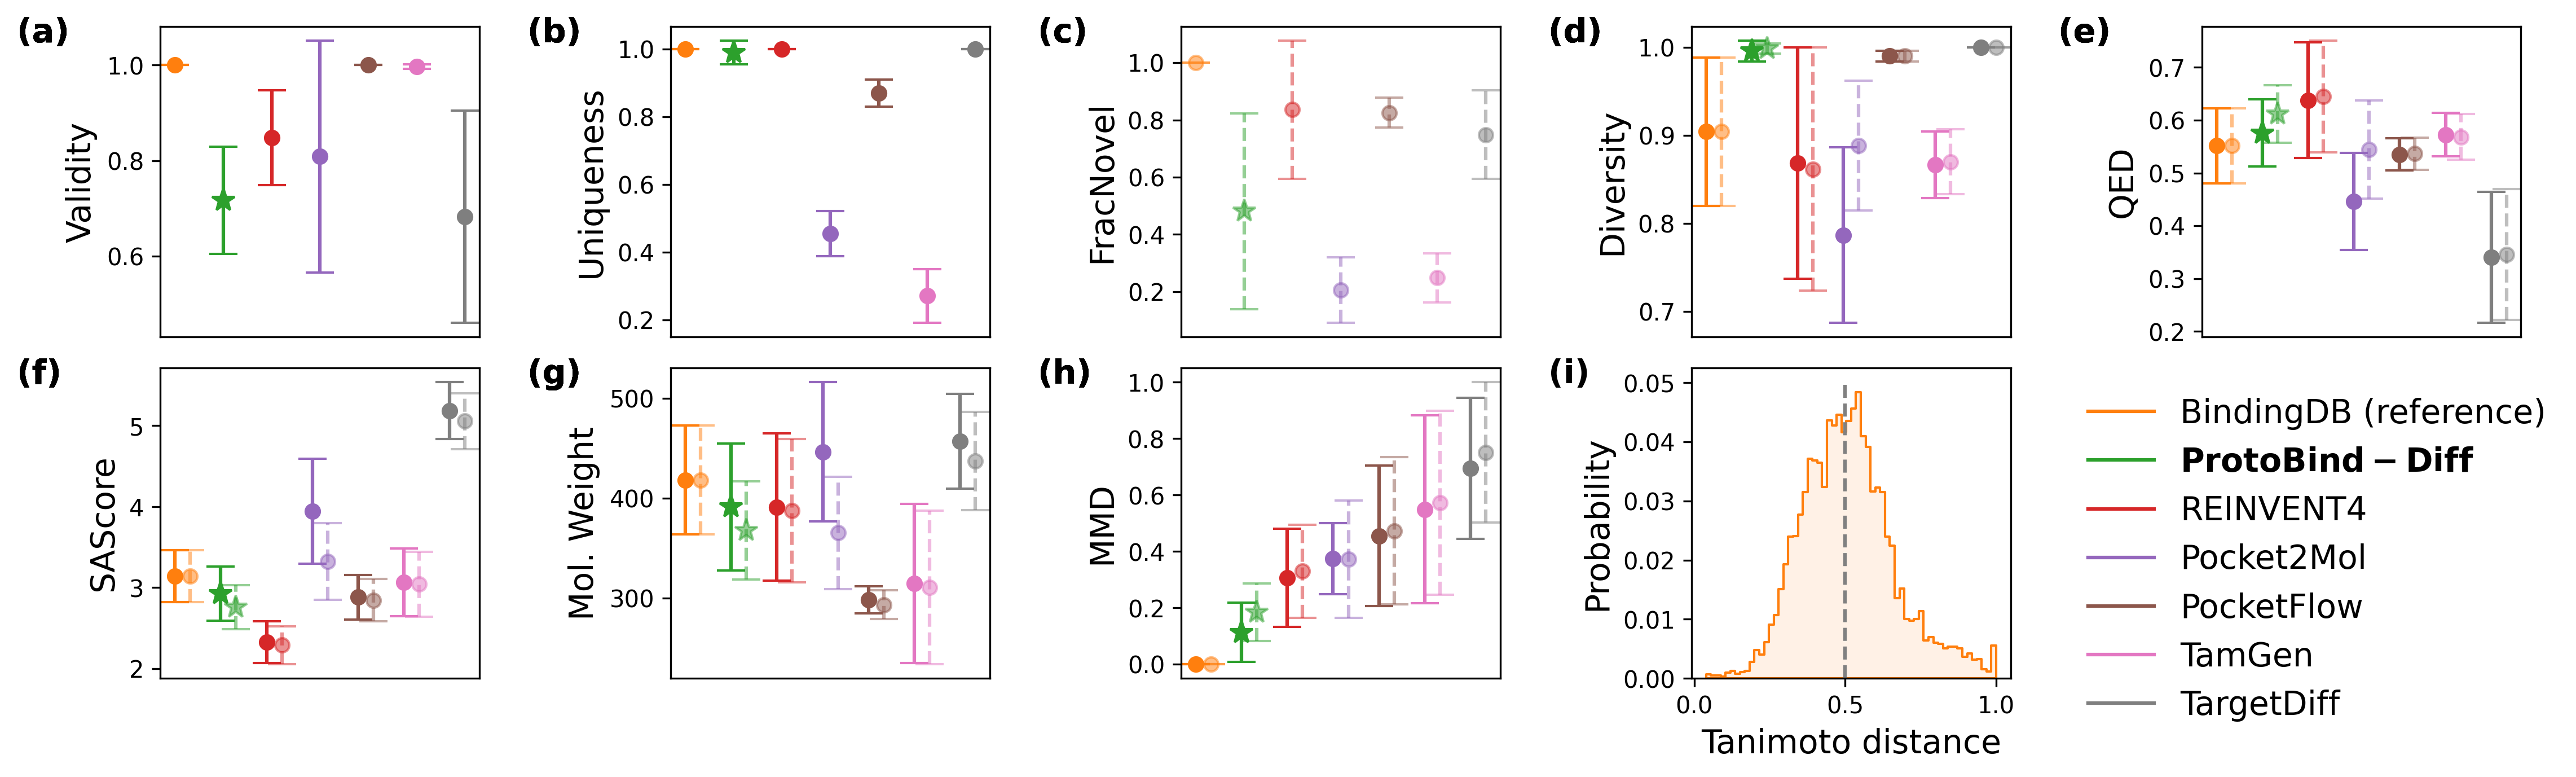

In [130]:
measurements = ['Validity', 'Uniqueness', 'FracNovel', 'Diversity', 'QED', 'SAScore', 'MolWt',  'MMD']

figure(figsize=(15, 8), dpi=400)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 5), dpi=300, facecolor='white', 
                         gridspec_kw={'wspace': 0.6, 'hspace': 0.1})
axes = axes.flatten()
colors = plt.cm.tab10.colors
p1 = [i*3 for i in range(len(df_metrics_T1.ModelName.unique()))]
p2 = [i*3+1 for i in range(len(df_metrics_T1.ModelName.unique()))]



for idx, measure in enumerate(measurements):
    ax = axes[idx]
    

    grouped = df_metrics_T1.groupby('ModelName')[measure]
    means_T1 = grouped.mean()
    stds_T1 = grouped.std()
    grouped = df_metrics_T05.groupby('ModelName')[measure]
    means_T05 = grouped.mean()
    stds_T05 = grouped.std()
        
    for i, model in enumerate(model_names):
        
        if model == 'protobind_diff':
            fmt='*'
            ms = 10
        else:
            fmt='o'
            ms = 6
        a1, a2 = 1, 0.5
        
        if idx not in [2]:
            ax.errorbar(x=p1[i], y=means_T1[model], yerr=stds_T1[model], ms=ms, alpha = a1, 
                            fmt=fmt, capsize=6, ls ='--', color=colors[i % len(colors)+1], label=model)
        
        if idx not in [0, 1]:
            err = ax.errorbar(x=p2[i], y=means_T05[model], yerr=stds_T05[model], ms=ms, alpha = a2, 
                        fmt=fmt, capsize=6, ls ='--', color=colors[i % len(colors)+1], label=model)
            for bar in err[2]: 
                bar.set_linestyle('--')

        ax.set_xticks([])
        ax.text(-0.45, 0.95, f'({string.ascii_lowercase[idx]})', transform=ax.transAxes, size=14, weight='bold')
        ax.set_ylabel(d1[measure], size=14)
        ax.set_facecolor('white')

legend_ax = axes[-1]
legend_ax.axis('off')
lines = []
for j, model in enumerate(model_names):
    if model == 'protobind_diff':
        line, = legend_ax.plot([], [], label='$\\bf{ProtoBind-Diff}$', color=colors[j+1], alpha=1.0)
    else:
        line, = legend_ax.plot([], [], label=f'{d2[model]}', color=colors[j+1], alpha=1.0)
    lines.append(line)
leg = legend_ax.legend(handles=lines, loc='upper left', prop={"size": 14}, frameon=False,
                 bbox_to_anchor=(-0.45, 1))
leg._legend_box.align = "left"


sns.histplot(all_mols, bins=60, fill=True, alpha=0.1, color=colors[1], linewidth=1,
            label=model, stat='probability', ax=axes[-2], element="step")

axes[-2].plot([0.5, 0.5], [0, 0.05], color='gray', linestyle='--')
axes[-2].set_xlabel('Tanimoto distance', size=14)
axes[-2].set_ylabel('Probability', size=14)
axes[-2].text(-0.45, 0.95, f'({string.ascii_lowercase[len(measurements)]})', 
              transform=axes[-2].transAxes, size=14, weight='bold')

plt.tight_layout()
fig.savefig(save_dir / f"prop0.png", bbox_inches='tight')

plt.show();

## Supplementary material

/var/folders/wf/rxy3k0rj26j21wb0ddpvcvq40000gn/T/ipykernel_98521/1675610886.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


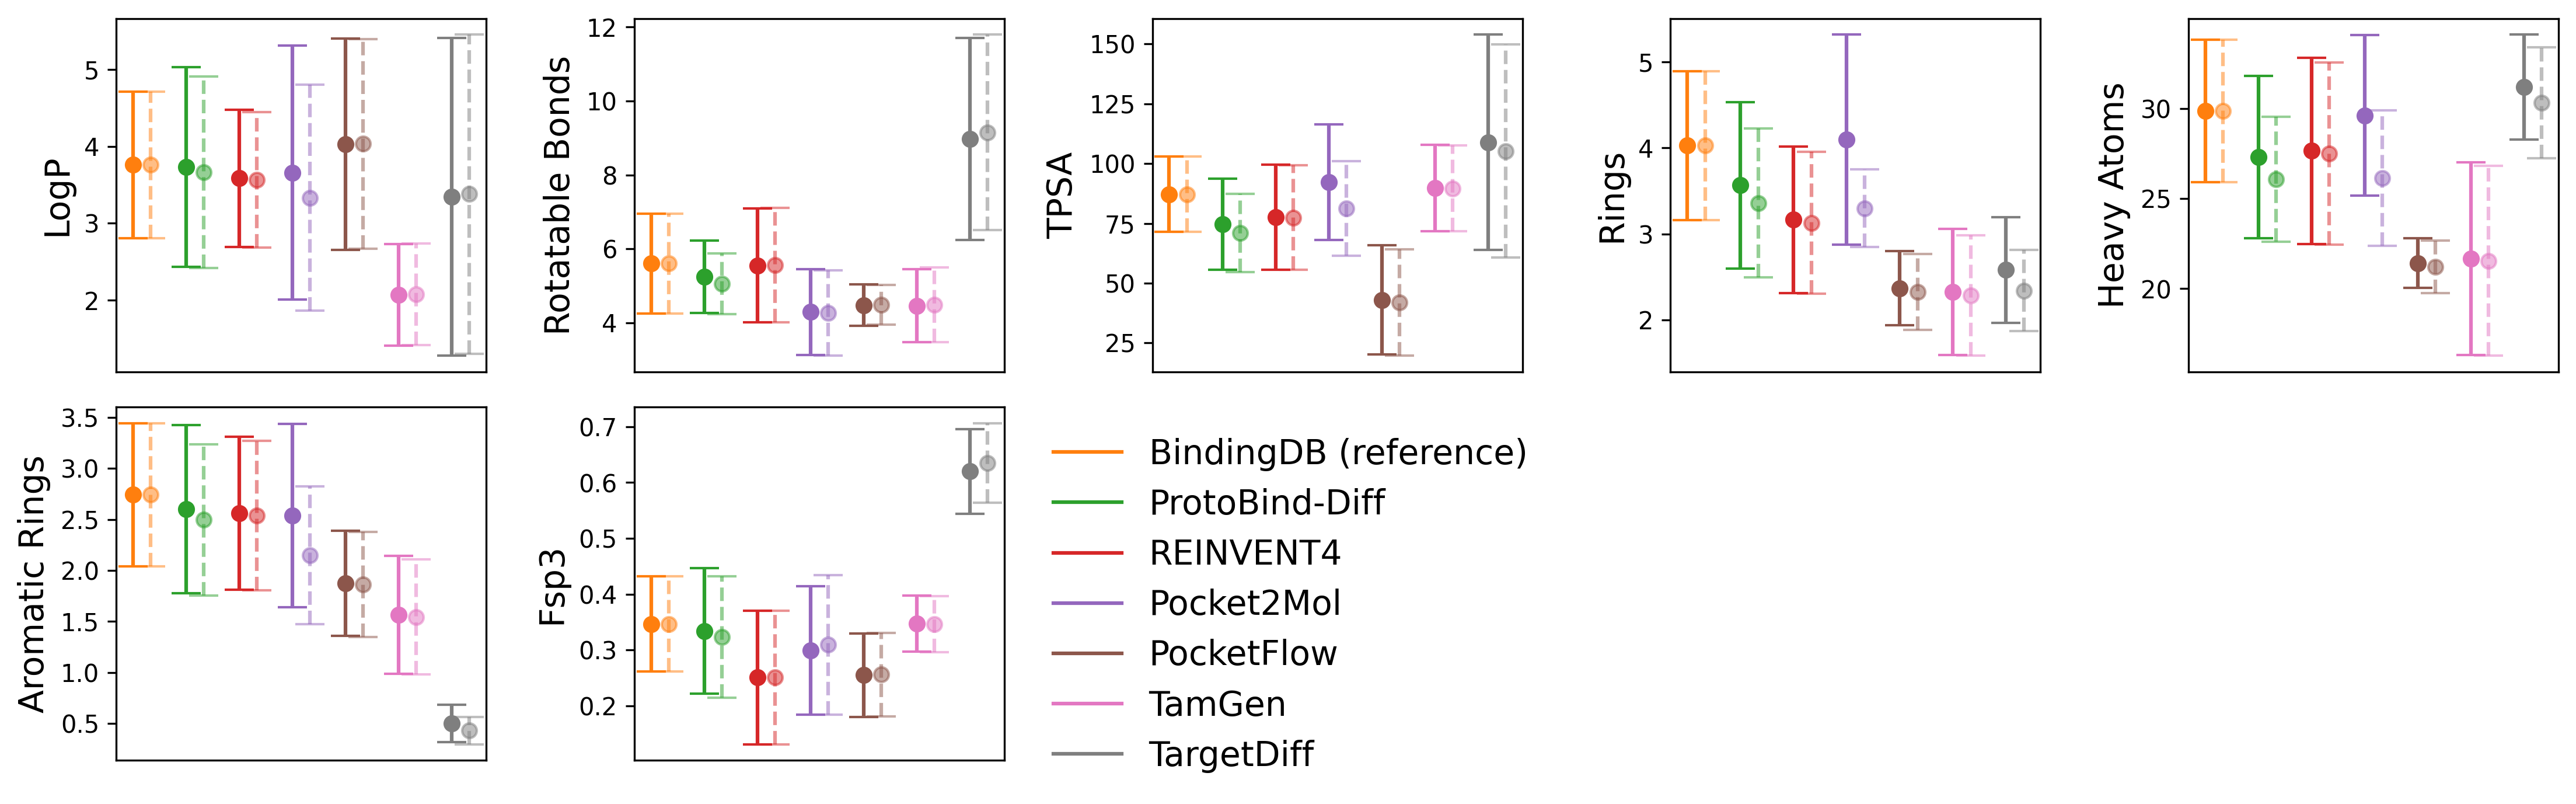

In [ ]:
measurements = ['MolLogP', 'NumRotatableBonds', 'CalcTPSA', 'RingCount', 
                'GetNumHeavyAtoms', 'CalcNumAromaticRings', 'CalcFractionCSP3']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 5.5), dpi=300, facecolor='white', 
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.1})
axes = axes.flatten()
colors = plt.cm.tab10.colors
p1 = [i*3 for i in range(len(df_metrics_T1.ModelName.unique()))]
p2 = [i*3+1 for i in range(len(df_metrics_T1.ModelName.unique()))]

for idx, measure in enumerate(measurements):
    ax = axes[idx]
    grouped = df_metrics_T1.groupby('ModelName')[measure]
    means_T1 = grouped.mean()
    stds_T1 = grouped.std()
    grouped = df_metrics_T05.groupby('ModelName')[measure]
    means_T05 = grouped.mean()
    stds_T05 = grouped.std()
        
    for i, model in enumerate(model_names):
        
        if model == 'protobind_diff':
            fmt='*'
            ms = 10
        else:
            fmt='o'
            ms = 6
        a1, a2 = 1, 0.5
            
        ax.errorbar(x=p1[i], y=means_T1[model], yerr=stds_T1[model], ms=ms, alpha = a1, 
                            fmt=fmt, capsize=6, ls ='--', color=colors[i % len(colors)+1], label=model)
        err = ax.errorbar(x=p2[i], y=means_T05[model], yerr=stds_T05[model], ms=ms, alpha = a2, 
                    fmt=fmt, capsize=6, ls ='--', color=colors[i % len(colors)+1], label=model)
        for bar in err[2]: 
            bar.set_linestyle('--')
        ax.set_xticks([])
        ax.set_ylabel(d1[measure], size=14)
        ax.set_facecolor('white')

legend_ax = axes[-3]
legend_ax.axis('off')
lines = []
for j, model in enumerate(model_names):
    if model == 'protobind_diff':
        line, = legend_ax.plot([], [], label='$\\bf{ProtoBind-Diff}$', color=colors[j+1], alpha=1.0)
    else:
        line, = legend_ax.plot([], [], label=f'{d2[model]}', color=colors[j+1], alpha=1.0)
    lines.append(line)
leg = legend_ax.legend(handles=lines, prop={"size": 14}, loc='upper left', frameon=False,
                 bbox_to_anchor=(-0.35, 1))
leg._legend_box.align = "left"
axes[-1].axis('off')
axes[-2].axis('off')
fig.savefig(save_dir / f"prop1.png", bbox_inches='tight')
plt.tight_layout()
plt.show();

/var/folders/wf/rxy3k0rj26j21wb0ddpvcvq40000gn/T/ipykernel_98521/830992676.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 6000x3200 with 0 Axes>

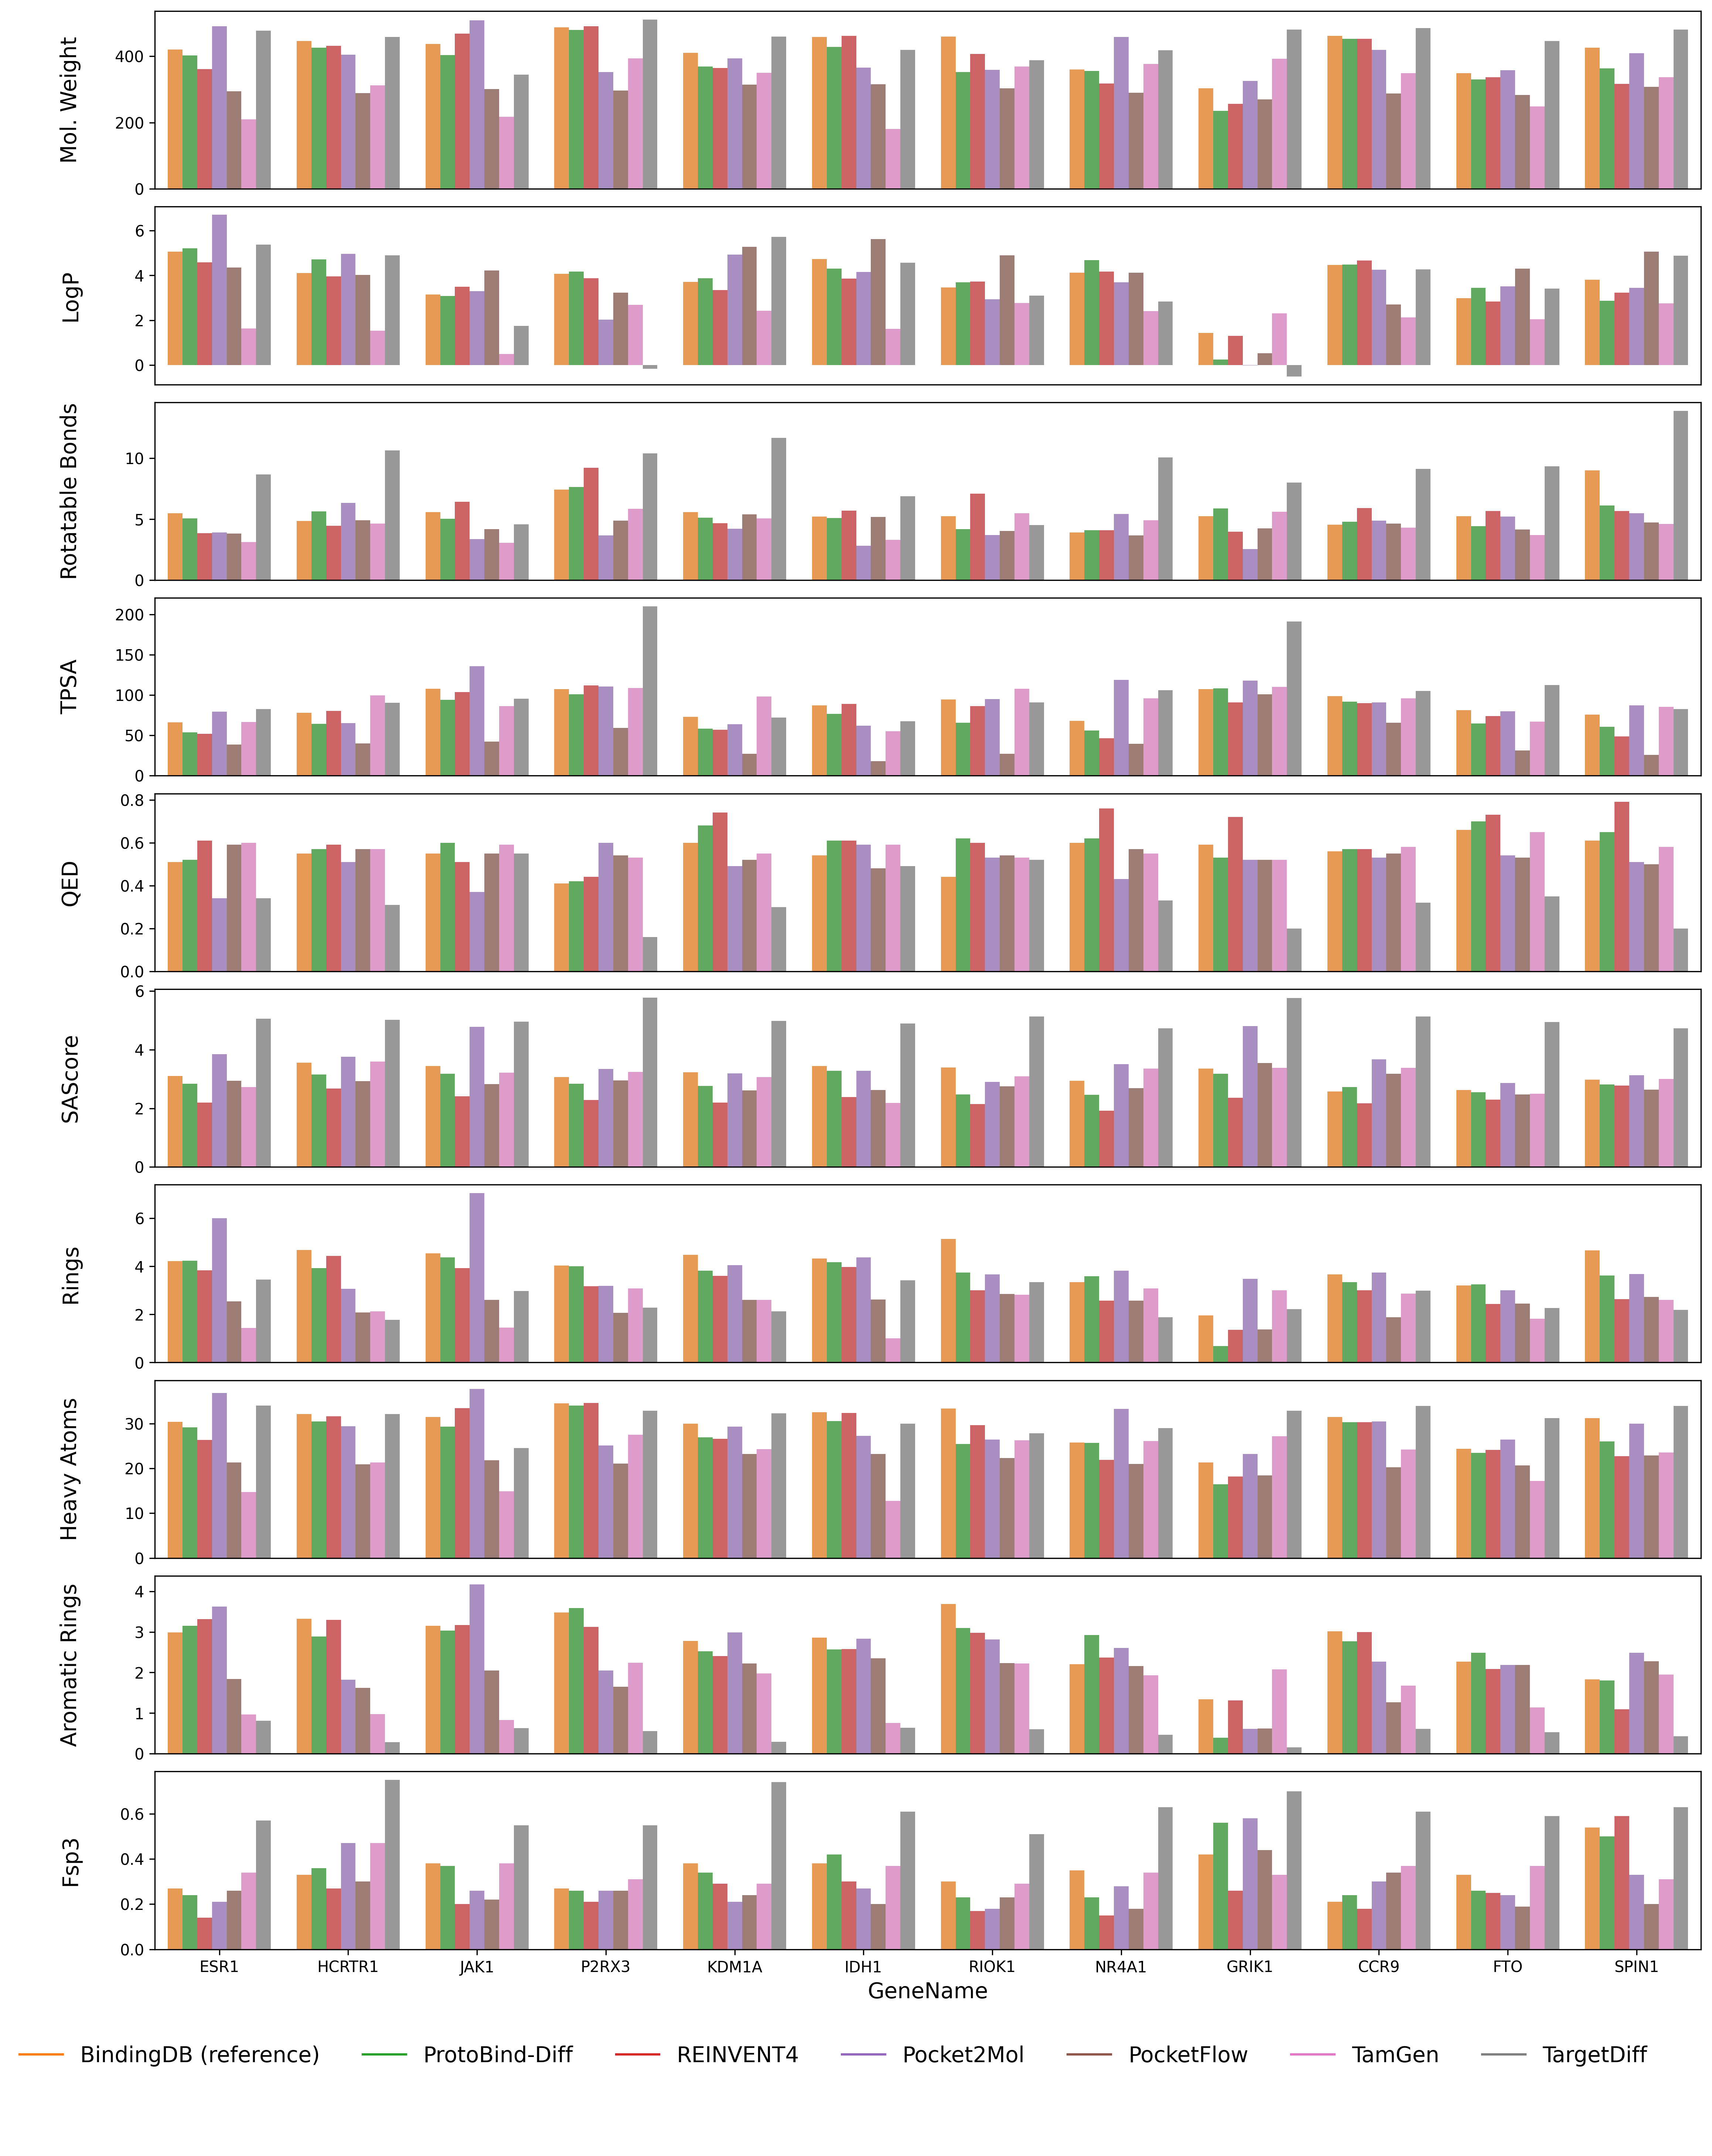

In [ ]:
measurements = ['MolWt', 'MolLogP', 'NumRotatableBonds', 'CalcTPSA', 'QED', 'SAScore', 
                'RingCount', 'GetNumHeavyAtoms', 'CalcNumAromaticRings', 'CalcFractionCSP3']
plt.rcParams['axes.labelsize'] = 14

colors = plt.cm.tab10.colors
figure(figsize=(15, 8), dpi=400)
fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(18, 25), dpi=300, facecolor='white', 
                         gridspec_kw={'wspace': 0.5, 'hspace': 0.1})
axes = axes.flatten()
models = model_names
for idx, measure in enumerate(measurements):
    sns.barplot(data=df_metrics_T1,
                y=measure, x='GeneName', hue='ModelName', palette=colors[1:], alpha=0.8, ax=axes[idx])
    axes[idx].legend([],[], frameon=False)
    axes[idx].set_ylabel(d1[measure], size=14)

    if idx < len(measurements)-1:
        axes[idx].set_xticks([])
        axes[idx].set_xlabel('')
    
legend_ax = axes[-1]
legend_ax.axis('off')
lines = []
for j, model in enumerate(models):
    if model == 'protobind_diff':
        line, = legend_ax.plot([], [], label='$\\bf{ProtoBind-Diff}$', color=colors[j+1], alpha=1.0)
    else:
        line, = legend_ax.plot([], [], label=f'{d2[model]}', color=colors[j+1], alpha=1.0)
    lines.append(line)
leg = legend_ax.legend(handles=lines, ncols=7, loc='center left', prop={"size": 14}, 
                       frameon=False, bbox_to_anchor=(-0.1, 0.5))
leg._legend_box.align = "left"
plt.tight_layout()
fig.align_ylabels(axes)
fig.savefig(save_dir / f"prop2.png", bbox_inches='tight')
plt.show();

## Tanimoto distance from generated mols to the active (true) mols from BindingDB

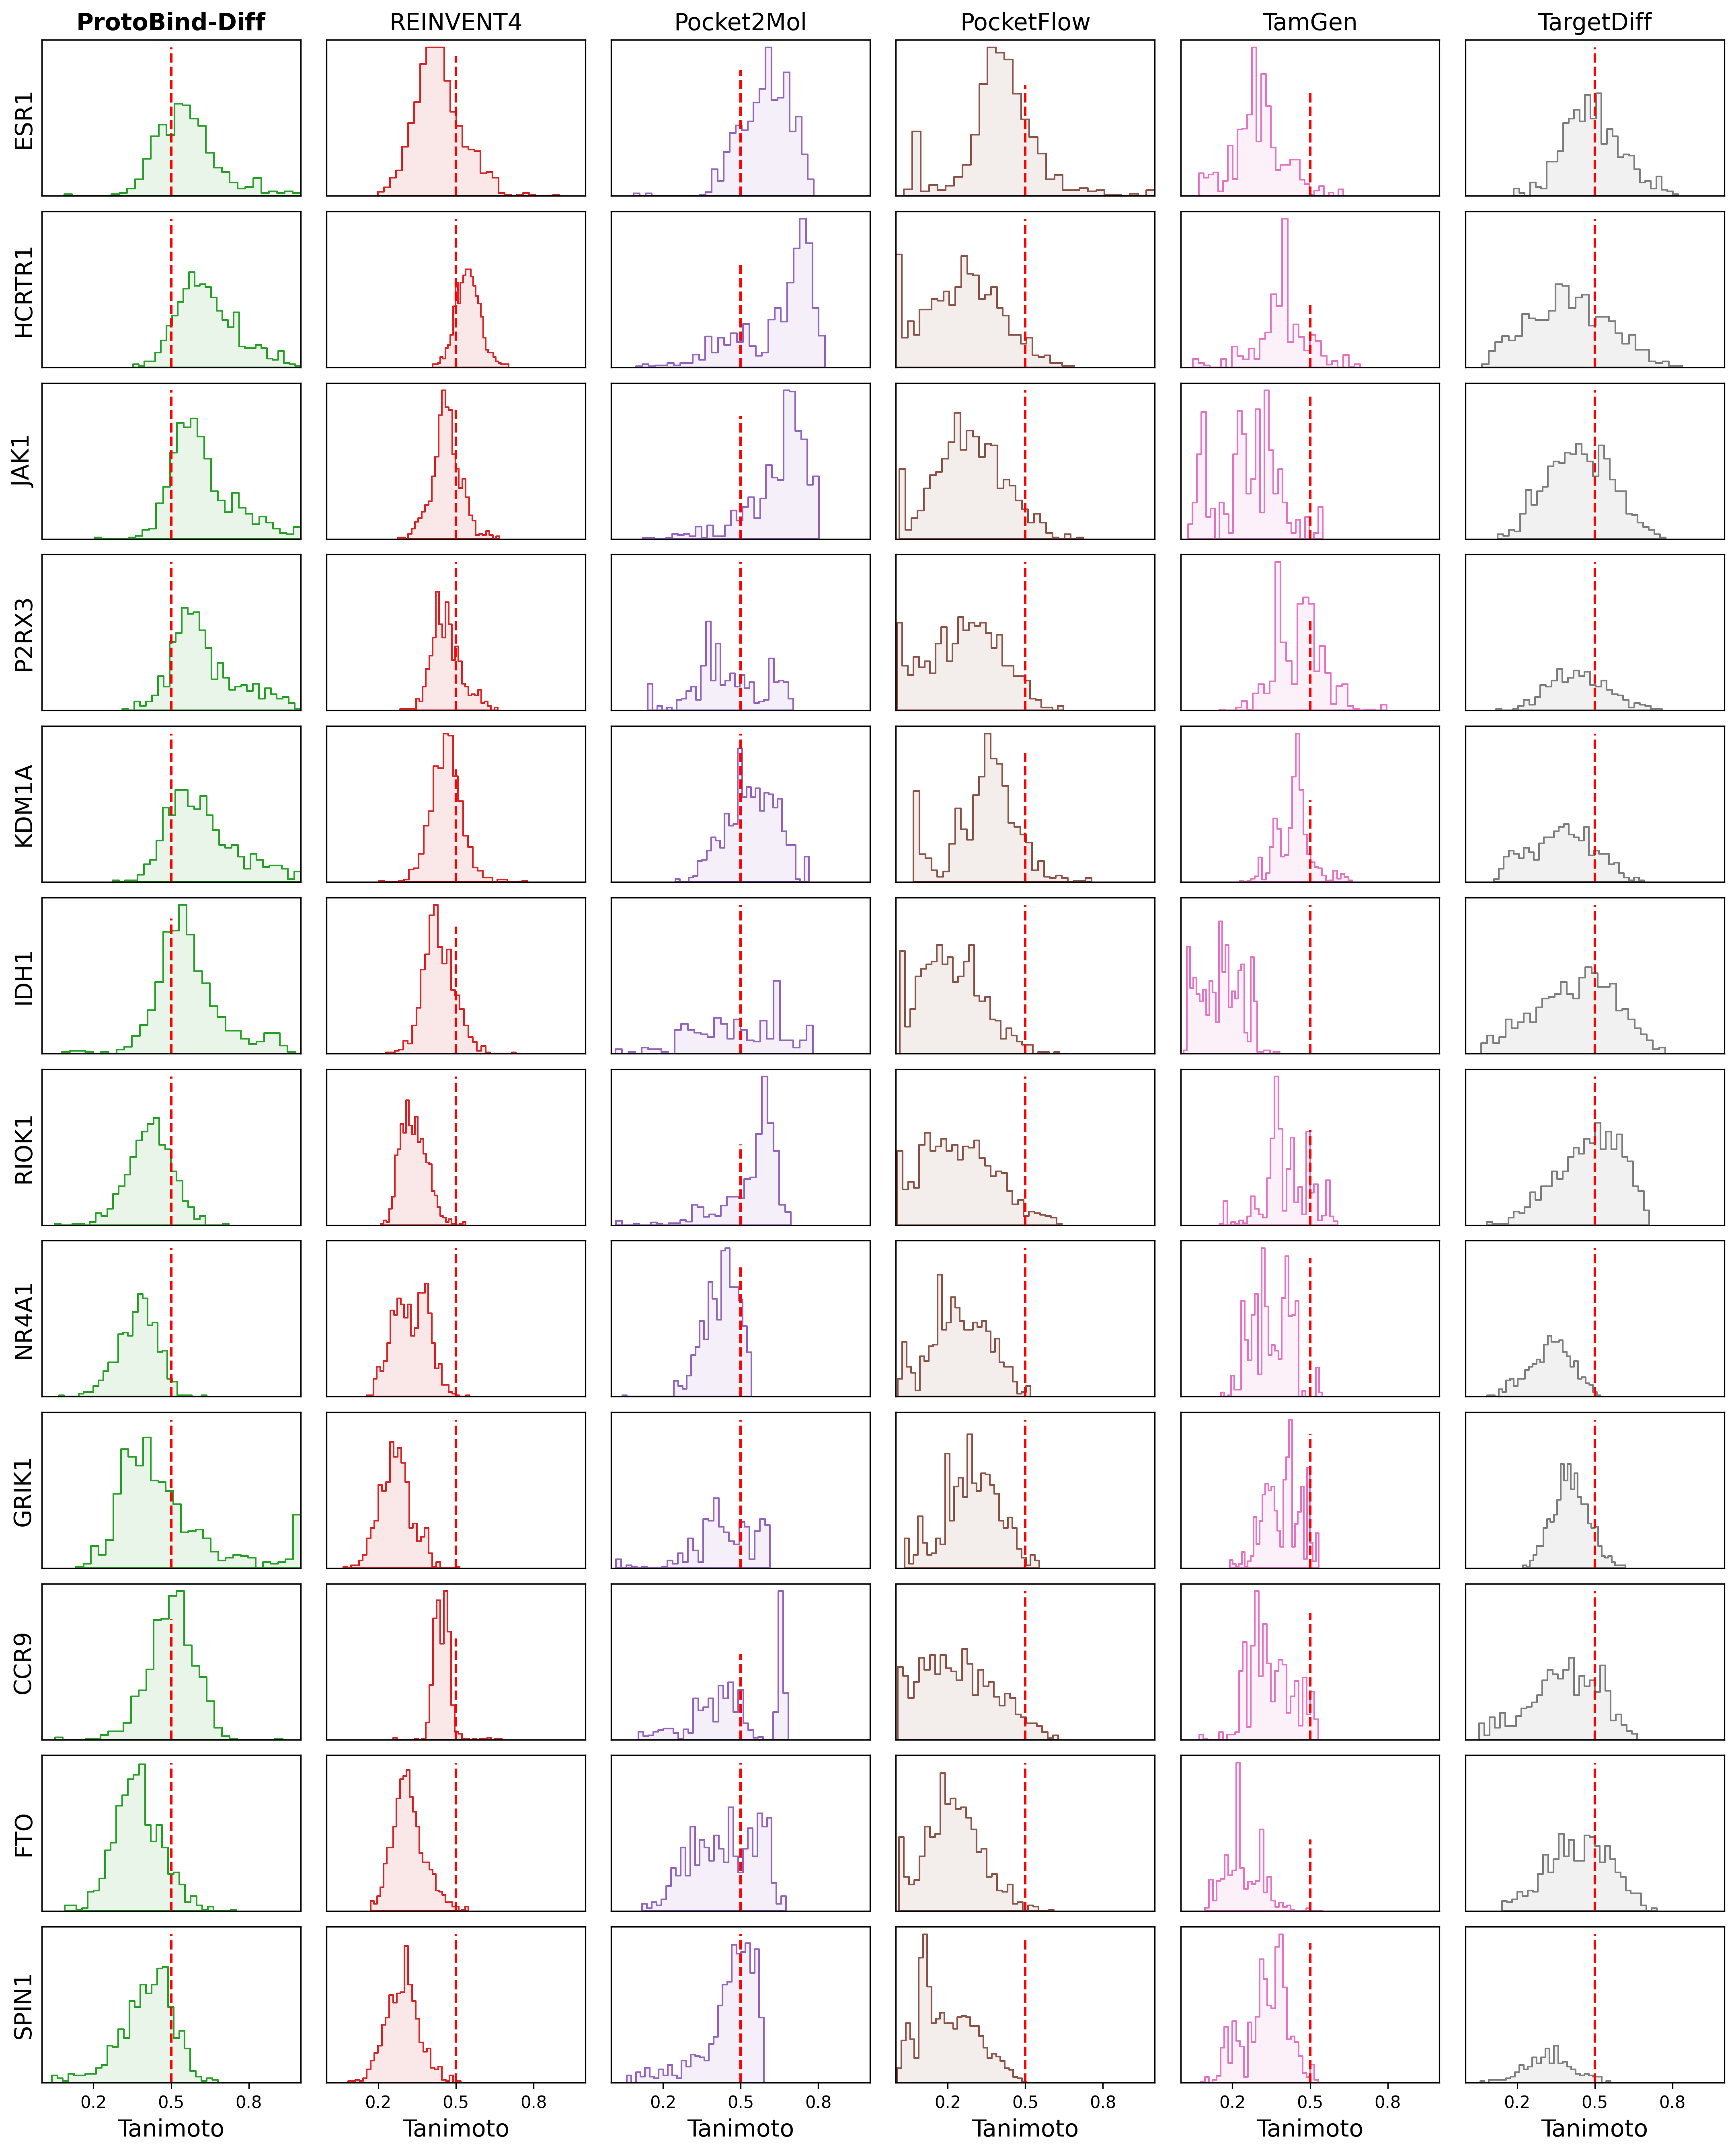

In [61]:
gene_list = name_order
colors = plt.cm.tab10.colors
models = model_names.copy()
models.pop(models.index('actives_bindingdb_cl'))

fig, axs = plt.subplots(12, 6, figsize=(18, 22), dpi=300, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs = axs.flatten()
for i, gene in enumerate(gene_list):
    for j, model in enumerate(models):
        
        ax = axs[6*i + j]
        df = pd.read_csv(gene2file[model][gene])
        if 'Tanimoto' in df.columns:
            h = sns.histplot(df.Tanimoto, bins=30, alpha=0.1, color=colors[j+2], 
                        label=model, stat='count', ax=ax, element="step")
        ax.plot([0.5, 0.5], [0, 100], color='red', linestyle='--')
        
        if i == 0:
            if model == 'protobind_diff':
                ax.set_title(d2[model], weight='bold', size=14)
            else:
                ax.set_title(d2[model], size=14)
        if j == 0:
            ax.set_ylabel(gene, size=14)
            ax.set_yticks([])
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
            
        if i == len(gene_list)-1:
            ax.set_xlabel('Tanimoto', size=14)
            ax.set_xticks([0.2, 0.5, 0.8])
        else:
            ax.set_xlabel('')
            ax.set_xticks([])
        ax.set_xlim((0, 1))

fig.savefig(save_dir / f"tanimoto.png", bbox_inches='tight')
plt.show();

In [60]:
models

['actives_bindingdb_cl',
 'protobind_diff',
 'reinvent',
 'pocket2mol',
 'pocketflow',
 'tamgen',
 'targetdiff']

In [55]:
d2

{'actives_bindingdb_cl': 'BindingDB (reference)',
 'protobind_diff': 'ProtoBind-Diff',
 'reinvent': 'REINVENT4',
 'pocket2mol': 'Pocket2Mol',
 'pocketflow': 'PocketFlow',
 'tamgen': 'TamGen',
 'targetdiff': 'TargetDiff'}